In [35]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

print(sklearn.__version__)

# Run this command to import the DataFrame from the other notebook
%store -r combinedInRangeDf

# Load the combined dataframe
#data = pd.read_csv(r'/Users/aaroncao/Documents/California Wildfire Project/combinedInRangeDf.csv')
data = combinedInRangeDf.copy()
print(data.head())

1.0.2
       STATION      AWND  AVG PRECIP  TOTAL PRECIP   AVG SNOW  TOTAL SNOW  \
0  USC00045091  5.363065    0.071429          0.50   0.540722    3.785052   
1  USC00045091  5.363065    0.240000          1.20   8.000000   16.000000   
2  USC00045091  5.363065    0.497143          3.48  13.200000   39.600000   
3  USC00045091  5.363065    0.741429          5.19  11.000000   33.000000   
4  USC00045091  5.309970    0.077143          0.54   0.800000    4.000000   

    AVG TEMP  AVG MAX TEMP  MAX TEMP  AVG MIN TEMP  MIN TEMP      TAVG2  \
0  47.376344     41.714286      50.0     27.142857      16.0  34.428571   
1  47.376344     42.857143      53.0     31.285714      22.0  37.071429   
2  47.376344     35.333333      46.0     11.166667       5.0  23.250000   
3  47.376344     34.857143      40.0      9.285714      -2.0  22.071429   
4  49.581029     53.142857      56.0     24.428571      18.0  38.785714   

   LATITUDE  LONGITUDE  ELEVATION       Begin         End  fire fire arr  \
0  3

In [36]:


# Assuming your dataframe is named 'df'
# Combine data from all weather stations
combined_data = data.copy()

combined_data.loc[data['fire'] == 'None', 'fire'] = 0
combined_data.loc[data['fire'] == 'minor', 'fire'] = 1
combined_data.loc[data['fire'] == 'major', 'fire'] = 1
# Shift the target variable to get the target for the next week
combined_data['fire next week'] = combined_data.groupby('STATION')['fire'].shift(-1)
combined_data['fire two weeks'] = combined_data.groupby('STATION')['fire'].shift(-2)
combined_data['fire three weeks'] = combined_data.groupby('STATION')['fire'].shift(-3)
combined_data['fire four weeks'] = combined_data.groupby('STATION')['fire'].shift(-4)
combined_data['fire five weeks'] = combined_data.groupby('STATION')['fire'].shift(-5)
combined_data['fire six weeks'] = combined_data.groupby('STATION')['fire'].shift(-6)
combined_data['fire seven weeks'] = combined_data.groupby('STATION')['fire'].shift(-7)
combined_data['fire eight weeks'] = combined_data.groupby('STATION')['fire'].shift(-8)
# Drop the last row with NaN target since there is no target for it
combined_data = combined_data.dropna()

# Define the size of the rolling window
#window_size = 7  # Number of previous weeks to consider
window_size = 20
#features with fire
#features = ['AWND', 'AVG PRECIP', 'TOTAL PRECIP','AVG SNOW','TOTAL SNOW','AVG TEMP','AVG MAX TEMP','MAX TEMP','AVG MIN TEMP','MIN TEMP','LATITUDE','LONGITUDE','ELEVATION', 'fire']
features = ['AWND', 'AVG PRECIP', 'TOTAL PRECIP','AVG SNOW','TOTAL SNOW','AVG TEMP','AVG MAX TEMP','MAX TEMP','AVG MIN TEMP','MIN TEMP','LATITUDE','LONGITUDE','ELEVATION']
target = ['fire next week', 'fire two weeks', 'fire three weeks', 'fire four weeks', 'fire five weeks', 'fire six weeks', 'fire seven weeks', 'fire eight weeks']

# Split data into features and target
X = combined_data[features]  # Features
y = combined_data[target]     # Target

# Apply rolling window to create sequences of inputs and targets
X_rolling = []
y_rolling = []

grouped_data = combined_data.groupby('STATION')
for group_name, group_data in grouped_data:
    group_size = len(group_data)
    # Iterate within the current group
    for i in range(group_size - window_size + 1):

        X_rolling.append(group_data[features].iloc[i:i+window_size].values.flatten())
        y_rolling.append(group_data[target].iloc[i+window_size-1])


# Convert to numpy arrays
X_rolling = pd.DataFrame(X_rolling)
y_rolling = pd.DataFrame(y_rolling)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_rolling, y_rolling, test_size=0.2, shuffle=True)

# Create and train the Random Forest classifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

predictions = model.predict_proba(X_test)  # probability output which needs to be classified into binary
# Evaluate the model on the test set

In [60]:
dt_arr = 0.25
y_test_np = np.array(y_test)
metric_graph_df = pd.DataFrame(columns=['week', 'accuracy', 'precision', 'recall', 'f1', 'auc_roc'])
#print(predictions)
#print(X_train.shape)
#print(y_train.shape)
#print(X_test.shape)
#print(y_test.shape)
row=len(predictions)
column=len(predictions[0])
print(f'Rows:{row}, Column:{column}')
for i, pred_array in enumerate(predictions): #i goes from 0 to 7 for the 8 rows, each column is a weeks prediction
    predictions_i_week = pred_array[:, 1] # take the second vertical row?
    y_test_i_week = y_test_np[:, i]
    binary_pred_i_week = (predictions_i_week >= dt_arr).astype(int)
    accuracy = accuracy_score(y_test_i_week, binary_pred_i_week)
    precision = precision_score(y_test_i_week, binary_pred_i_week)
    recall = recall_score(y_test_i_week, binary_pred_i_week)
    f1 = f1_score(y_test_i_week, binary_pred_i_week)
    #auc_roc = roc_auc_score(y_test_i_week, binary_pred_i_week)
    auc_roc = roc_auc_score(y_test_i_week, predictions_i_week)
    df_to_add = pd.DataFrame({'week':(i+1), 'accuracy':accuracy, 'precision':precision, 'recall':recall, 'f1':f1, 'auc_roc':auc_roc}, index=[0])
    metric_graph_df = pd.concat([metric_graph_df, df_to_add])
    print(f"Metrics for week {i+1}: --------------------")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision} | Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"AUC-ROC: {auc_roc}")
    
    #print("----------------------------------")


Rows:8, Column:1637
Metrics for week 1: --------------------
Accuracy: 0.9285277947464875
Precision: 0.5178571428571429 | Recall: 0.7073170731707317
F1 Score: 0.5979381443298969
AUC-ROC: 0.950282458570953
Metrics for week 2: --------------------
Accuracy: 0.9425778863775198
Precision: 0.6172839506172839 | Recall: 0.7575757575757576
F1 Score: 0.6802721088435375
AUC-ROC: 0.9530831571529246
Metrics for week 3: --------------------
Accuracy: 0.9309712889431888
Precision: 0.489010989010989 | Recall: 0.8165137614678899
F1 Score: 0.6116838487972508
AUC-ROC: 0.957995100629233
Metrics for week 4: --------------------
Accuracy: 0.9456322541233965
Precision: 0.593939393939394 | Recall: 0.8166666666666667
F1 Score: 0.6877192982456141
AUC-ROC: 0.9525928367391783
Metrics for week 5: --------------------
Accuracy: 0.9462431276725718
Precision: 0.608433734939759 | Recall: 0.8145161290322581
F1 Score: 0.6965517241379311
AUC-ROC: 0.9718115045945888
Metrics for week 6: --------------------
Accuracy: 0.93

  week  accuracy  precision    recall        f1   auc_roc
0    1  0.928528   0.517857  0.707317  0.597938  0.950282
0    2  0.942578   0.617284  0.757576  0.680272  0.953083
0    3  0.930971   0.489011  0.816514  0.611684  0.957995
0    4  0.945632   0.593939  0.816667  0.687719  0.952593
0    5  0.946243   0.608434  0.814516  0.696552  0.971812
0    6  0.937691   0.572289  0.753968  0.650685  0.957909
0    7  0.935247   0.547771  0.710744  0.618705  0.959634
0    8  0.941967   0.569697  0.796610  0.664311  0.960643


/Users/aaroncao/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


<AxesSubplot:xlabel='week'>

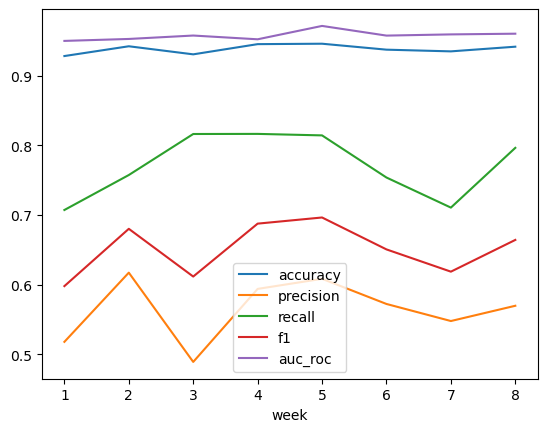

In [38]:
print(metric_graph_df)
metric_graph_df.plot(x='week', y=['accuracy', 'precision', 'recall', 'f1', 'auc_roc'])

/Users/aaroncao/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


(0.0, 1.0)

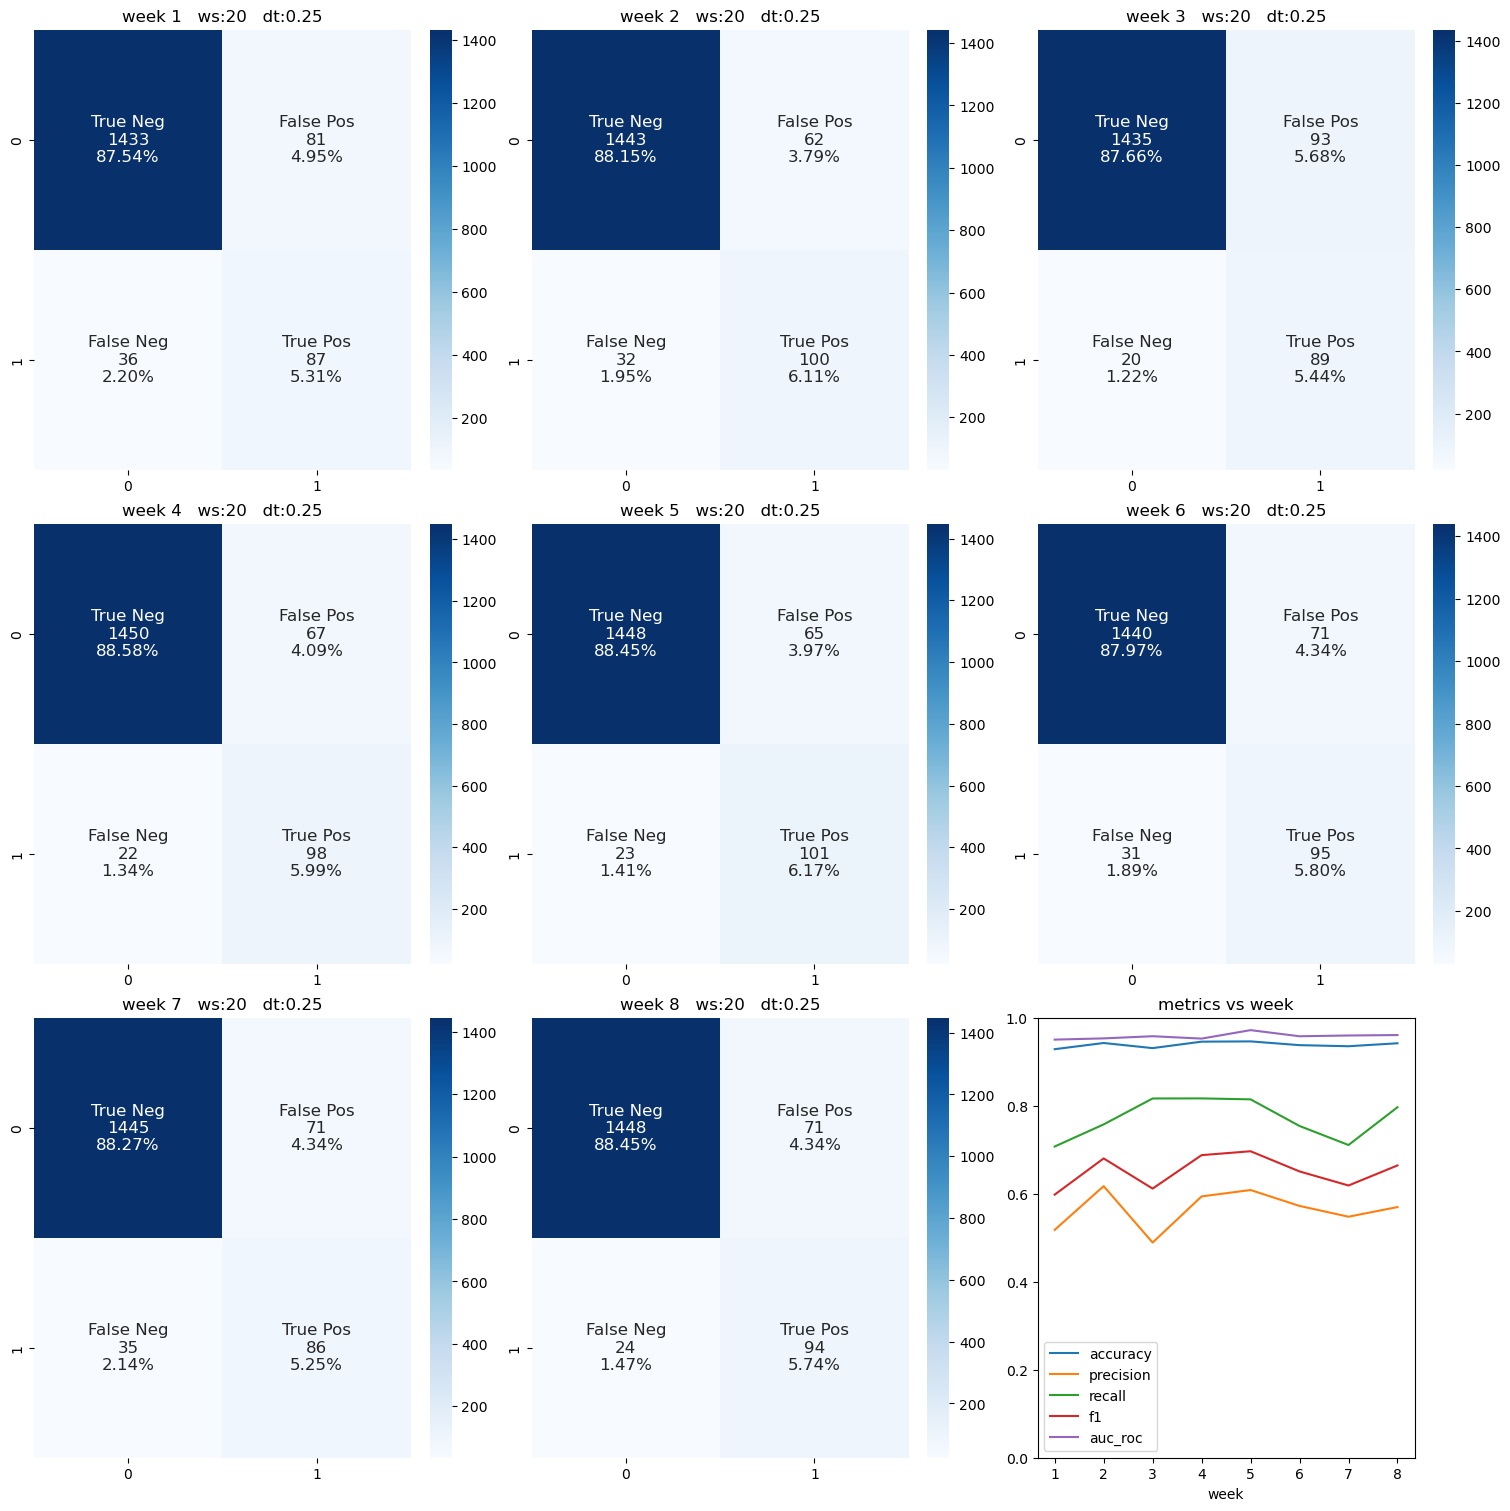

In [39]:
fig, ax = plt.subplots(3,3, constrained_layout = True, figsize=(15,15))

for i, pred_array in enumerate(predictions):
    predictions_i_week = pred_array[:, 1]
    y_test_i_week = y_test_np[:, i]
    binary_pred_i_week = (predictions_i_week >= dt_arr).astype(int)
    
    cf_matrix = confusion_matrix(y_test_i_week, binary_pred_i_week)
    group_names = ['True Neg','False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    #sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    title = 'week '+str(i+1)+'   ws:'+str(window_size)+"   dt:"+str(dt_arr)
    sns.heatmap(cf_matrix, annot=labels, annot_kws={"fontsize":12}, fmt='', cmap='Blues', ax=ax[int(i/3)][i%3]).set(title=title)
#ax[2,2].set_axis_off()
metric_graph_df.plot(x='week', y=['accuracy', 'precision', 'recall', 'f1', 'auc_roc'], ax = ax[2,2], title = 'metrics vs week')
plt.legend(loc='best')
ax[2,2].set_ylim([0, 1])


/Users/aaroncao/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aaroncao/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aaroncao/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aaroncao/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics

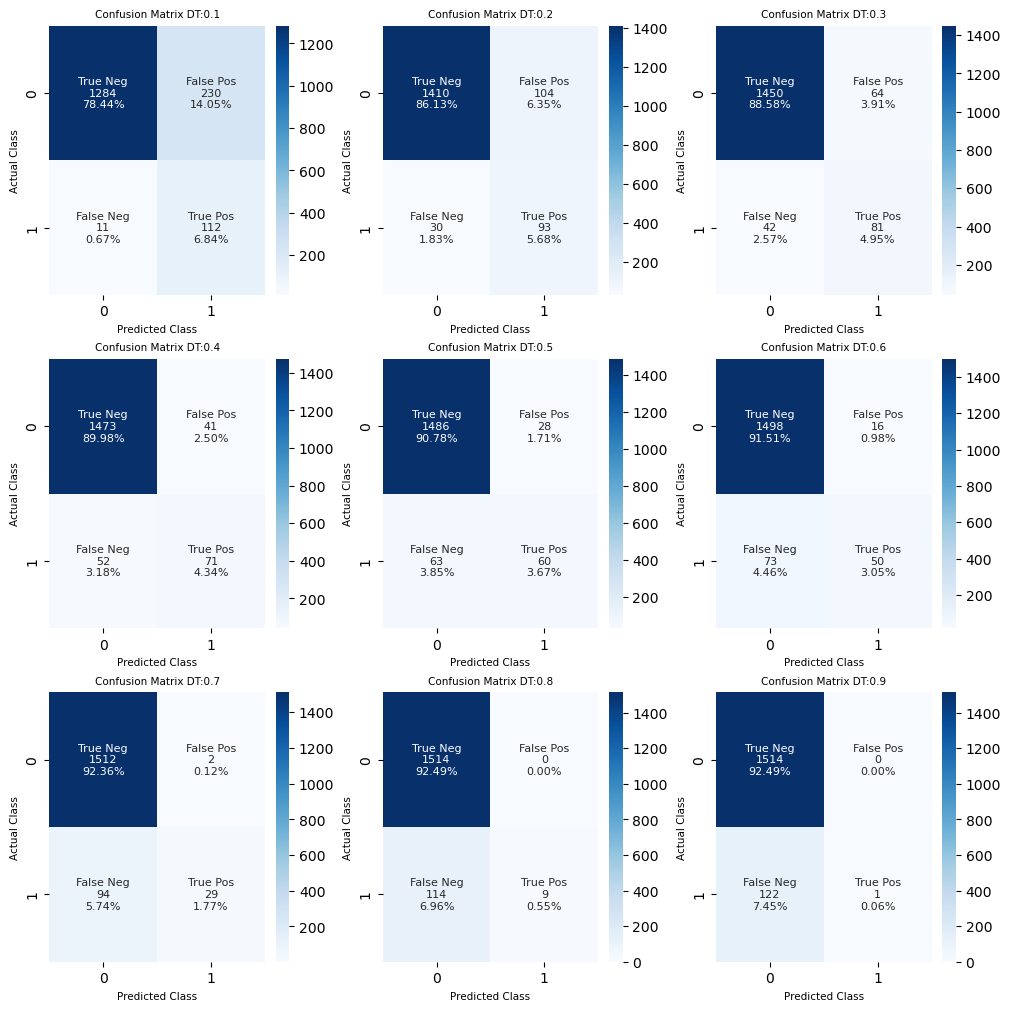

/Users/aaroncao/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aaroncao/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aaroncao/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aaroncao/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics

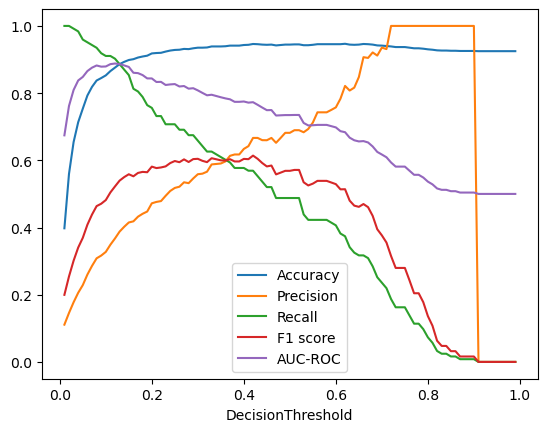

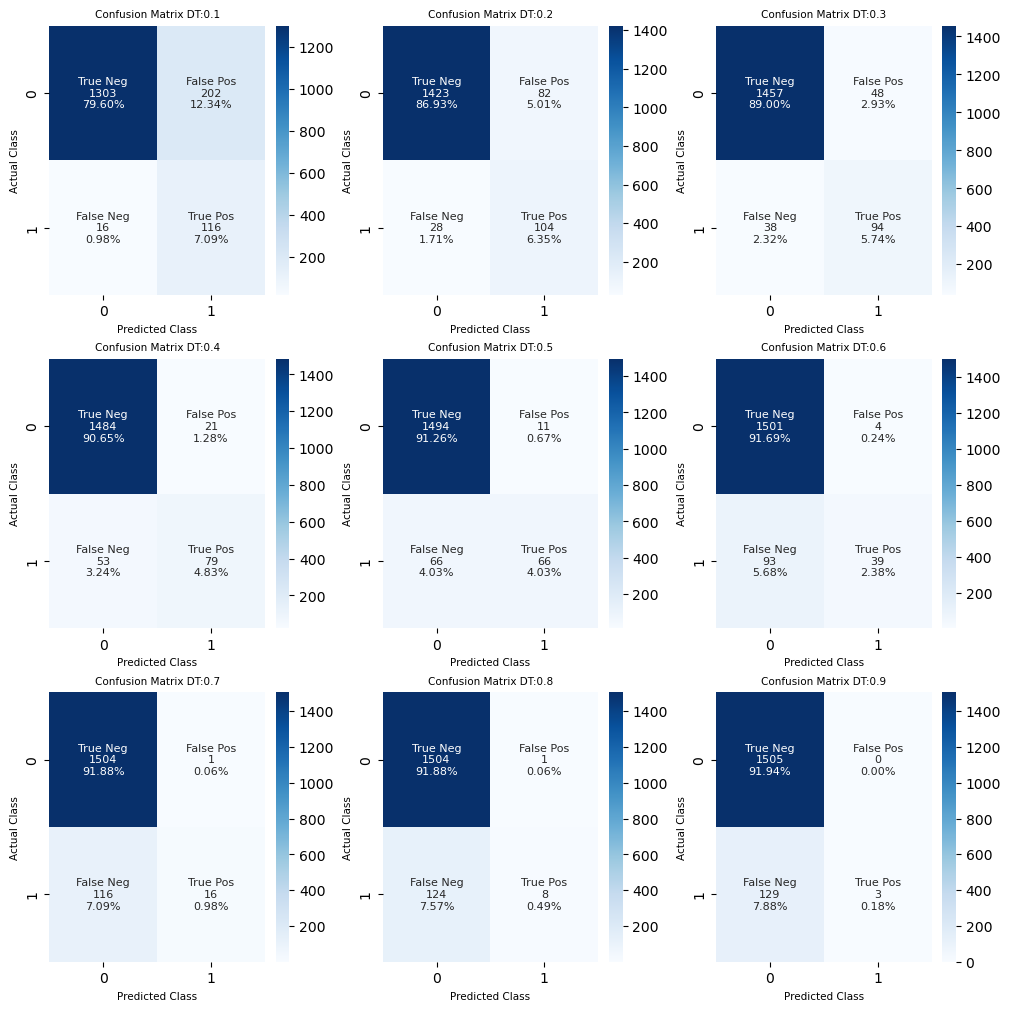

/Users/aaroncao/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aaroncao/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aaroncao/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aaroncao/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics

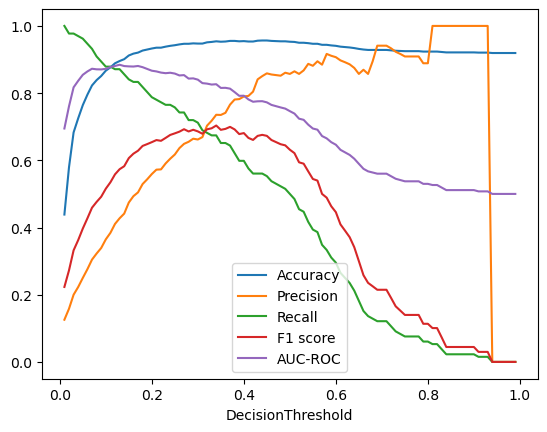

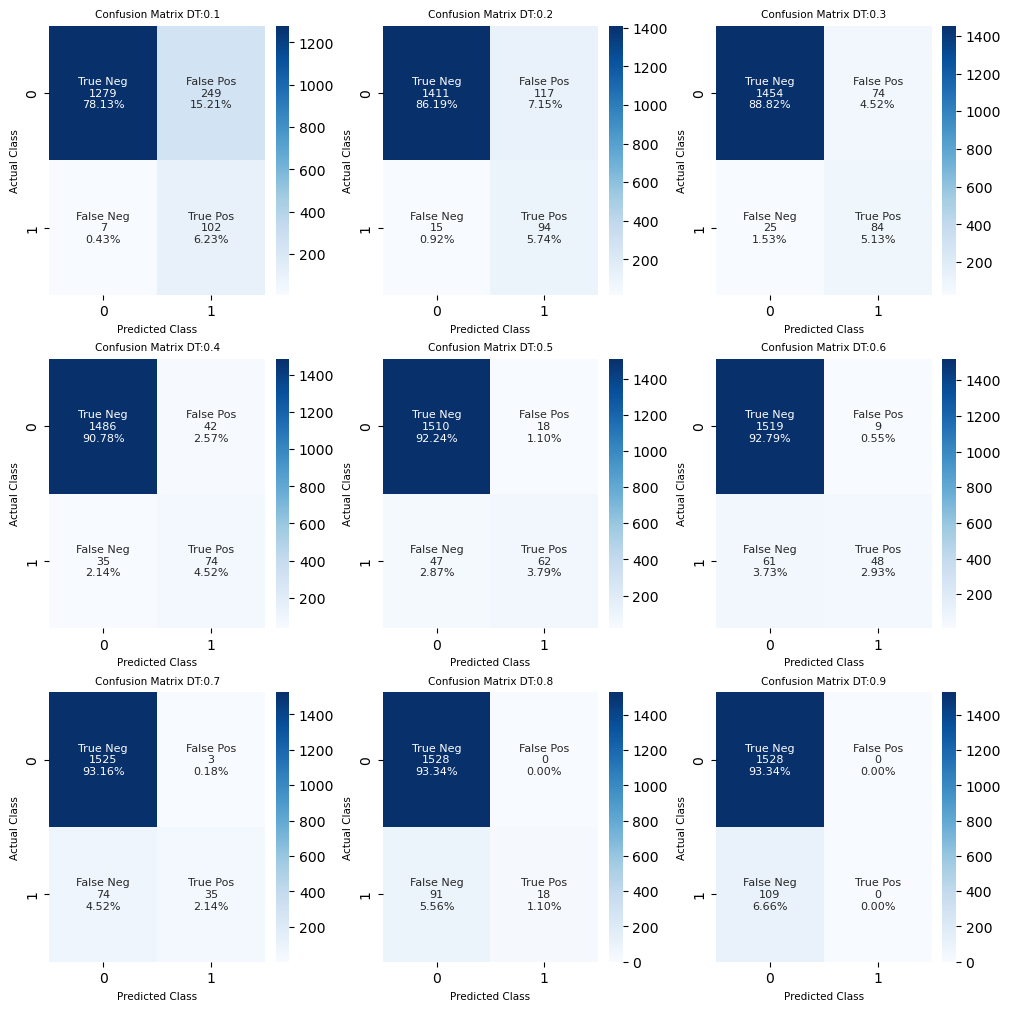

/Users/aaroncao/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aaroncao/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aaroncao/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aaroncao/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics

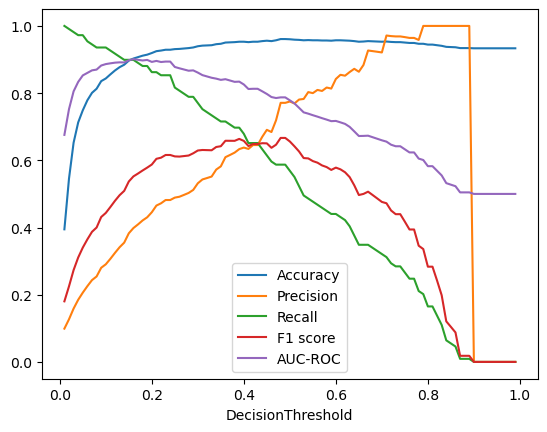

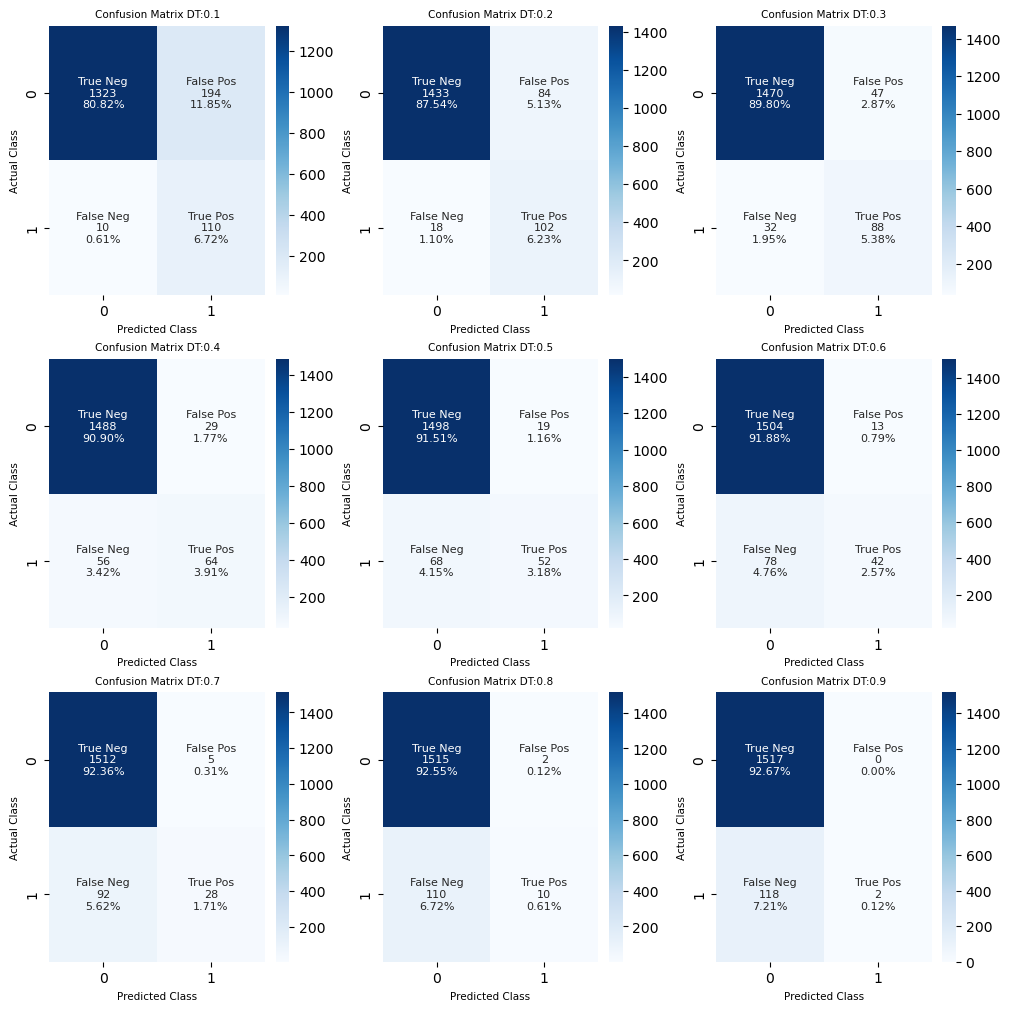

/Users/aaroncao/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aaroncao/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aaroncao/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aaroncao/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics

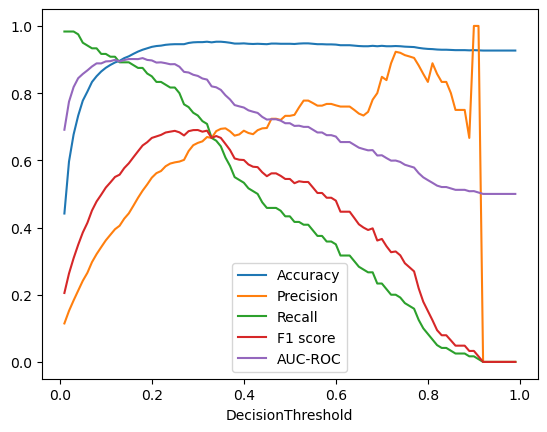

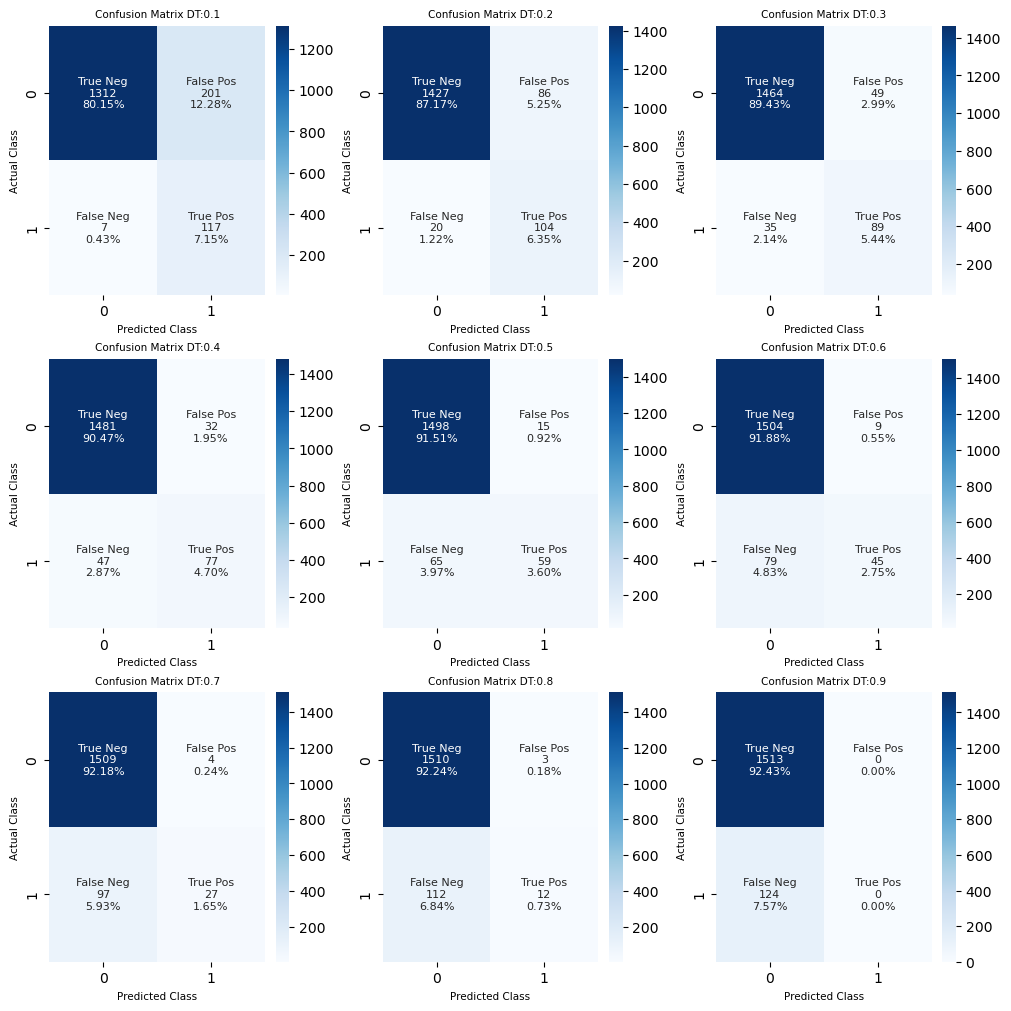

/Users/aaroncao/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aaroncao/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aaroncao/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aaroncao/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics

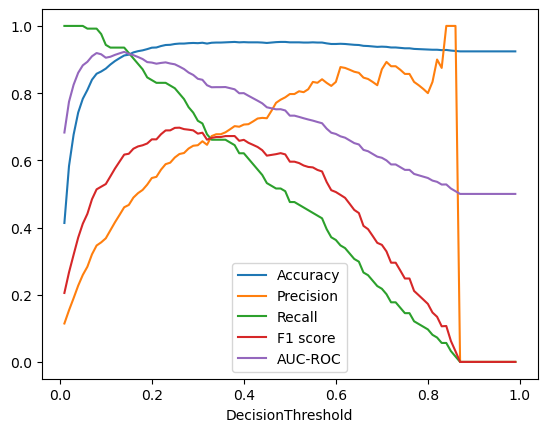

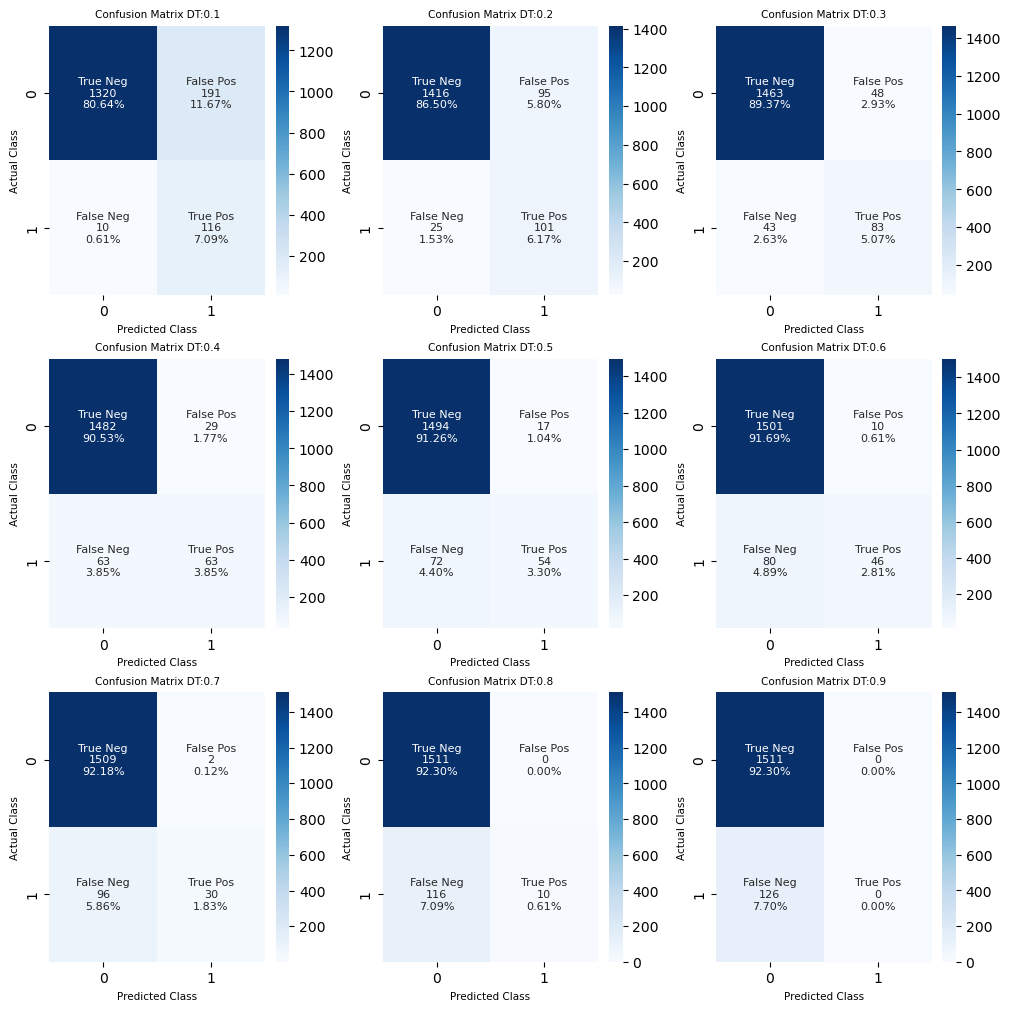

/Users/aaroncao/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aaroncao/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aaroncao/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aaroncao/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics

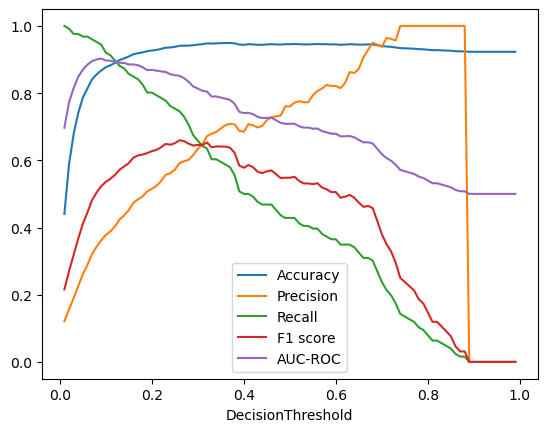

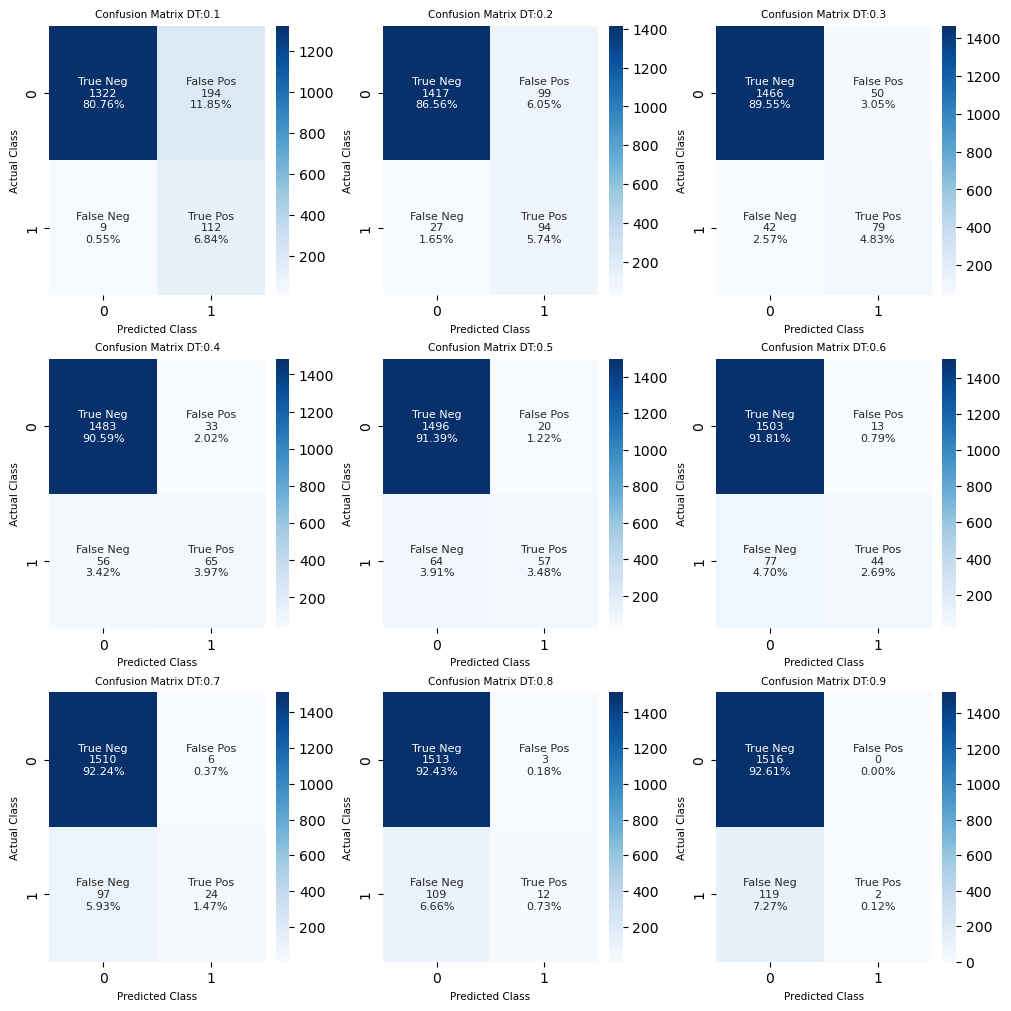

/Users/aaroncao/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aaroncao/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aaroncao/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aaroncao/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics

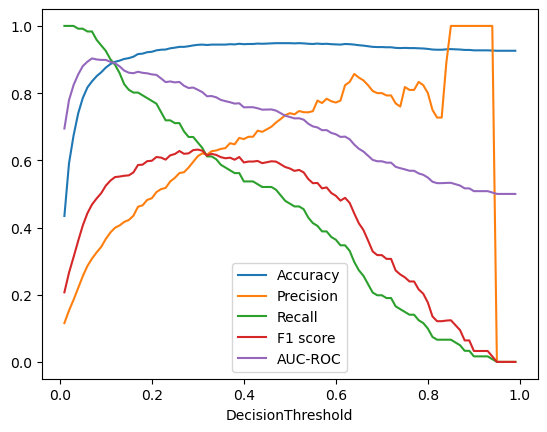

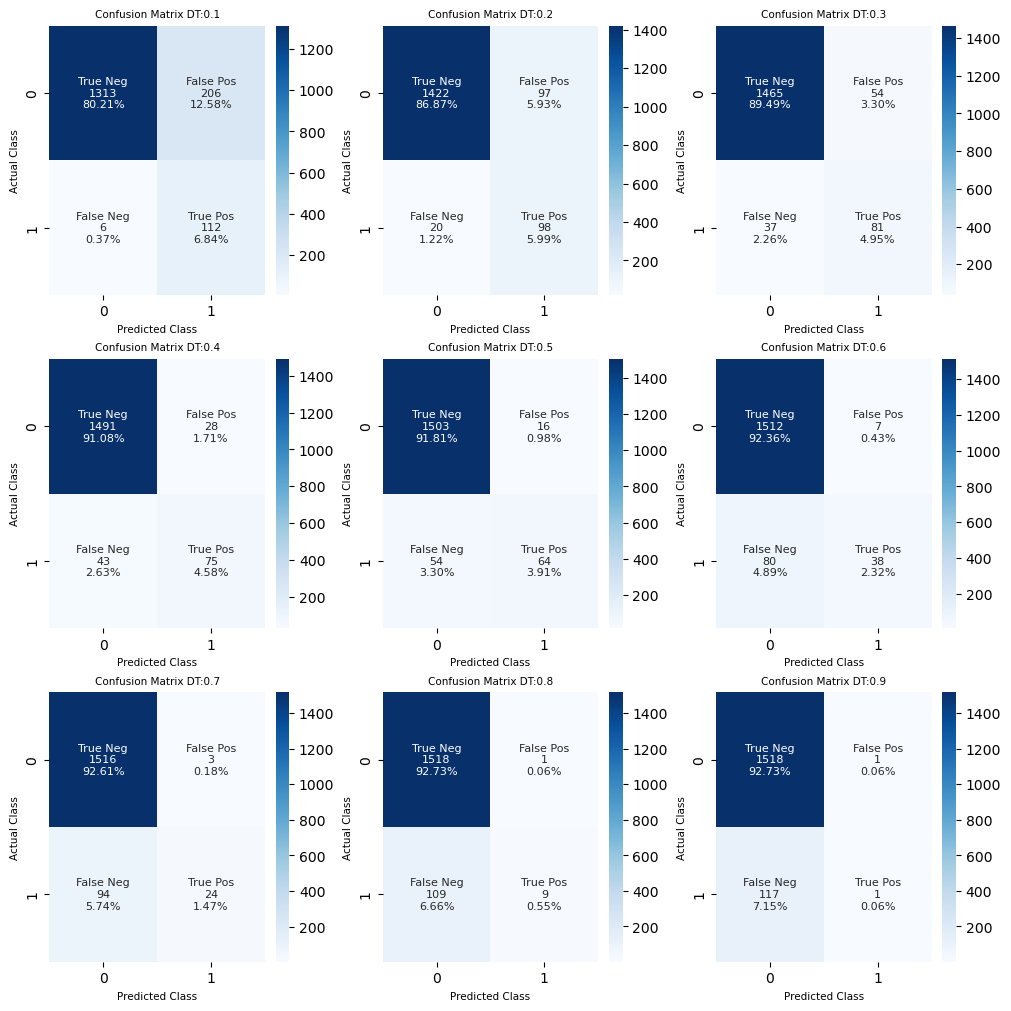

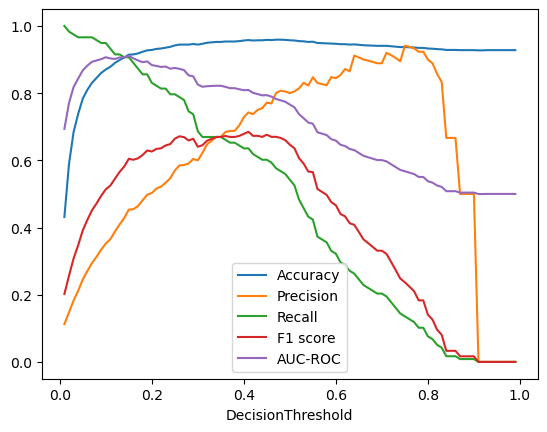

In [40]:
for i, pred_array in enumerate(predictions):
    predictions_i_week = pred_array[:, 1] #y_pred
    y_test_i_week = y_test_np[:, i] #y_test

    fig, ax = plt.subplots(3,3, constrained_layout = True, figsize=(10,10))

    decisionThresholdArr = np.zeros(shape=(99,6), dtype=float) #float is less storage than double?

    for i in range(99):

        decision_threshold = (i+1)/100
        binary_prediction_i_week=(predictions_i_week >= decision_threshold).astype(int)

        precision=precision_score(y_test_i_week, binary_prediction_i_week)
        recall = recall_score(y_test_i_week, binary_prediction_i_week) #PRIORITIZE RECALL!!!!!
        f1 = f1_score(y_test_i_week, binary_prediction_i_week)
        auc_roc = roc_auc_score(y_test_i_week, binary_prediction_i_week)
        accuracy = accuracy_score(y_test_i_week, binary_prediction_i_week)
        
        decisionThresholdArr[i, 0]= decision_threshold
        decisionThresholdArr[i, 1]= accuracy
        decisionThresholdArr[i, 2]= precision
        decisionThresholdArr[i, 3]= recall
        decisionThresholdArr[i, 4]= f1
        decisionThresholdArr[i, 5]= auc_roc

        #print('Decision Threshold:', decision_threshold)
        if (((i+1)%10)==0): 
            #1 2 3 4 5 6 7 8 9
            #0 0 1 1 1 2 2 2 3
            ind = int(i/10)
            
            cf_matrix = confusion_matrix(y_test_i_week, binary_prediction_i_week)
            group_names = ['True Neg','False Pos', 'False Neg', 'True Pos']
            group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
            group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
            labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
            labels = np.asarray(labels).reshape(2,2)
            #sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
            sns.heatmap(cf_matrix, annot=labels, annot_kws={"fontsize":8}, fmt='', cmap='Blues', ax=ax[int(ind/3)][ind%3])
            ax[int(ind/3)][ind%3].set_xlabel('Predicted Class', fontsize=7.5)
            ax[int(ind/3)][ind%3].set_ylabel('Actual Class', fontsize=7.5)
            title = 'Confusion Matrix DT:'+ str(decision_threshold)
            ax[int(ind/3)][ind%3].set_title(title, size=7.5)

        #print('Accuracy:', accuracy)
        #print('Precision:', precision)
        #print('Recall:', recall)
        #print('F1 score:', f1)
        #print('AUC-ROC:', auc_roc)
        #print('----------------------------------------')


    plt.show()
        
    #y_pred = (y_pred > 0.5).astype(int)

    decisionThresholdDf = pd.DataFrame(decisionThresholdArr, columns=['DecisionThreshold', 'Accuracy', 'Precision', 'Recall', 'F1 score', 'AUC-ROC'])
    decisionThresholdDf.plot(x='DecisionThreshold', y=['Accuracy', 'Precision', 'Recall', 'F1 score', 'AUC-ROC'])


In [53]:
%store -r finalWeeklyWeatherDf
newTestWeatherDf = finalWeeklyWeatherDf.copy()
print(newTestWeatherDf)

           DATE      STATION       AWND      Begin        End  AVG PRECIP  \
0    2022-05-29  US1CARV0005   7.987143 2022-05-29 2022-06-04         0.0   
1    2022-06-05  US1CARV0005  10.291429 2022-06-05 2022-06-11         0.0   
2    2022-06-12  US1CARV0005  10.098571 2022-06-12 2022-06-18         0.0   
3    2022-06-19  US1CARV0005   9.205714 2022-06-19 2022-06-25         0.0   
4    2022-06-26  US1CARV0005   0.000000 2022-06-26 2022-07-02         0.0   
...         ...          ...        ...        ...        ...         ...   
2400 2023-04-23  USW00093138   7.412857 2023-04-23 2023-04-29         0.0   
2401 2023-04-30  USW00093138  10.032857 2023-04-30 2023-05-06         0.0   
2402 2023-05-07  USW00093138   8.851429 2023-05-07 2023-05-13         0.0   
2403 2023-05-14  USW00093138   7.572857 2023-05-14 2023-05-20         0.0   
2404 2023-05-21  USW00093138   7.426000 2023-05-21 2023-05-27         0.0   

      TOTAL PRECIP  AVG SNOW  TOTAL SNOW   AVG TEMP  AVG MAX TEMP  MAX TEMP

US1CARV0005
[0.65 0.03 0.63 0.04 0.06 0.01 0.01 0.64]


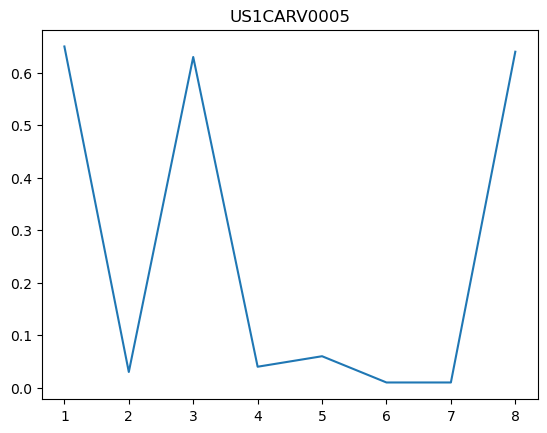

US1CARV0015
[0.65 0.03 0.63 0.04 0.06 0.01 0.01 0.64]


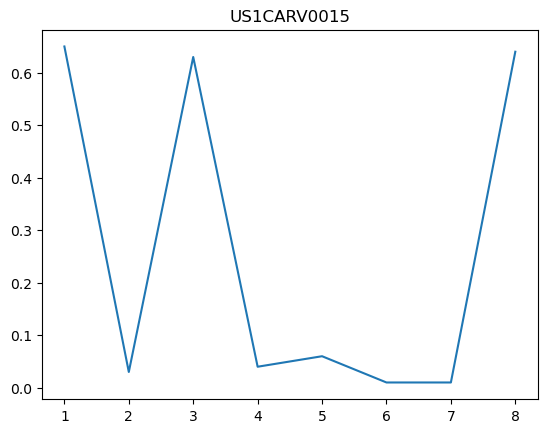

US1CARV0018
[0.65 0.03 0.63 0.04 0.06 0.01 0.01 0.64]


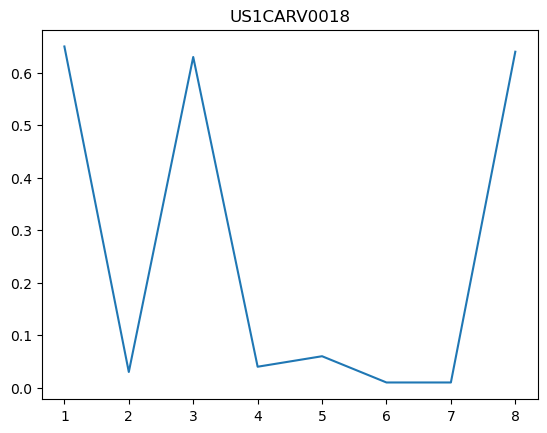

US1CARV0034
[0.65 0.03 0.63 0.04 0.06 0.01 0.01 0.64]


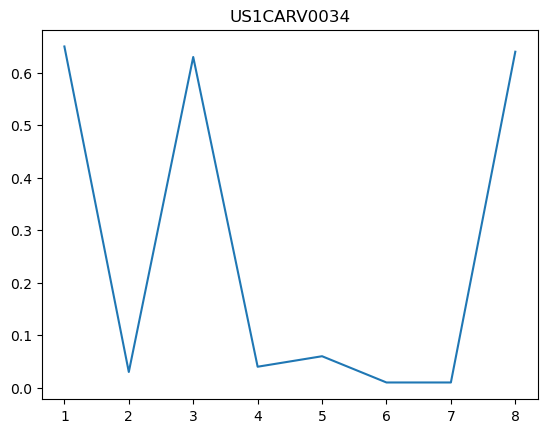

US1CARV0036
[0.65 0.03 0.63 0.04 0.06 0.01 0.01 0.64]


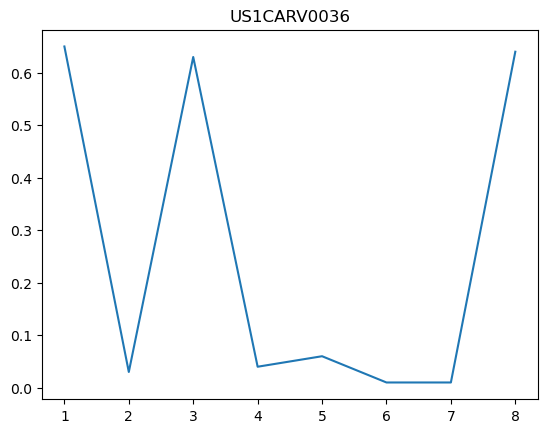

US1CARV0038
[0.65 0.03 0.63 0.04 0.06 0.01 0.01 0.64]


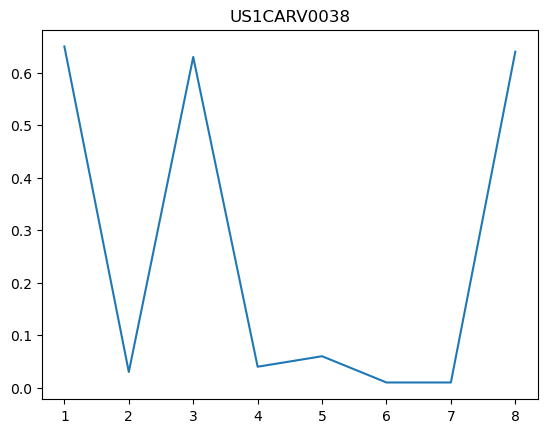

US1CARV0043
[0.65 0.03 0.63 0.04 0.06 0.01 0.01 0.64]


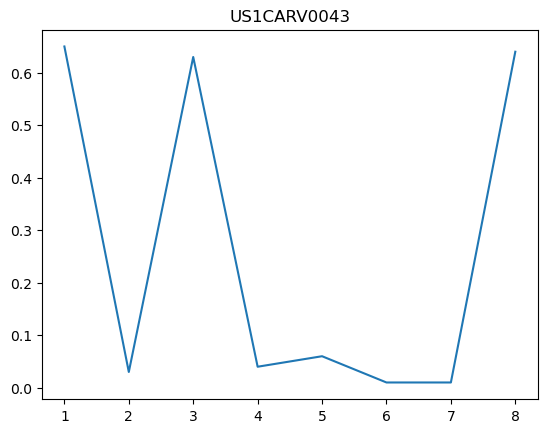

US1CARV0050
[0.65 0.03 0.63 0.04 0.06 0.01 0.01 0.64]


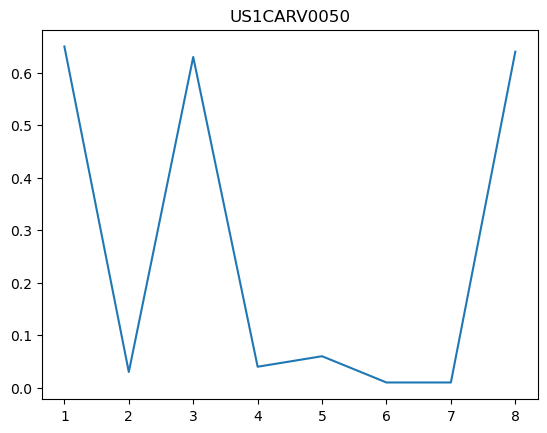

US1CARV0058
[0.65 0.03 0.63 0.04 0.06 0.01 0.01 0.64]


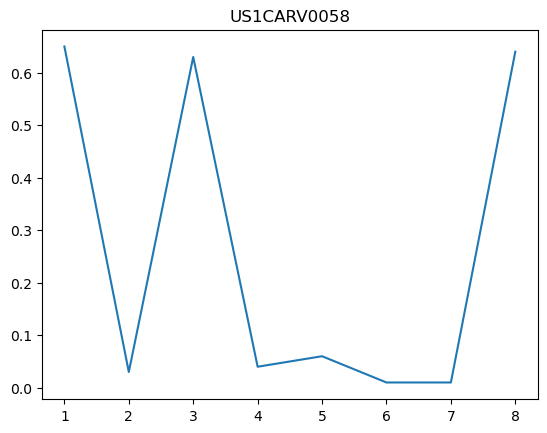

US1CARV0060
[0.65 0.03 0.63 0.04 0.06 0.01 0.01 0.64]


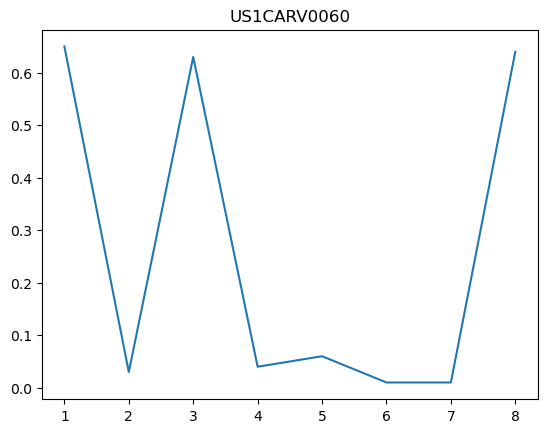

US1CARV0061
[0.65 0.03 0.63 0.04 0.06 0.01 0.01 0.64]


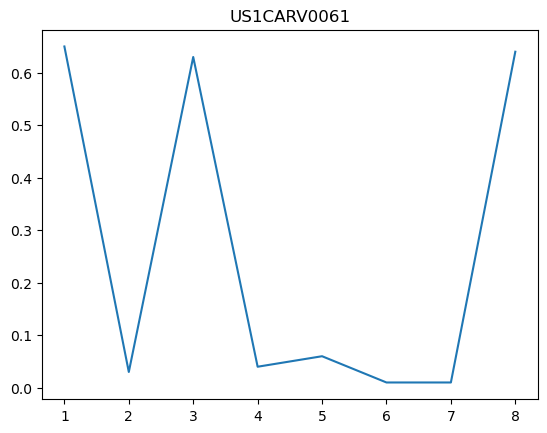

US1CARV0065
[0.65 0.03 0.63 0.04 0.06 0.01 0.01 0.64]


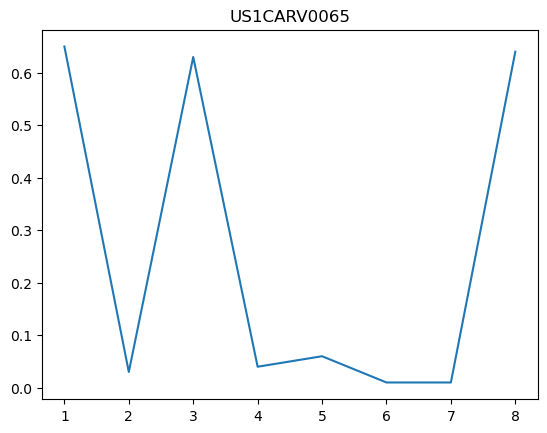

US1CARV0072
[0.65 0.03 0.63 0.04 0.06 0.01 0.01 0.64]


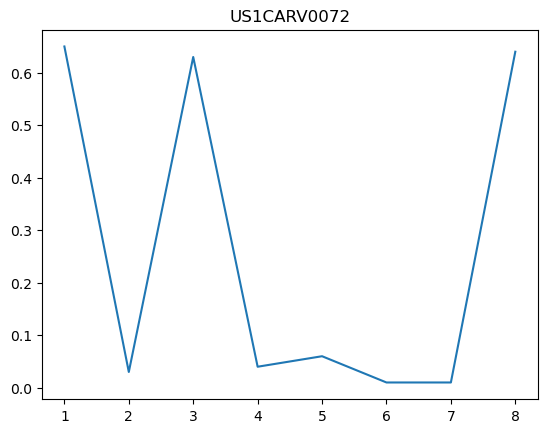

US1CARV0077
[0.65 0.03 0.63 0.04 0.06 0.01 0.01 0.64]


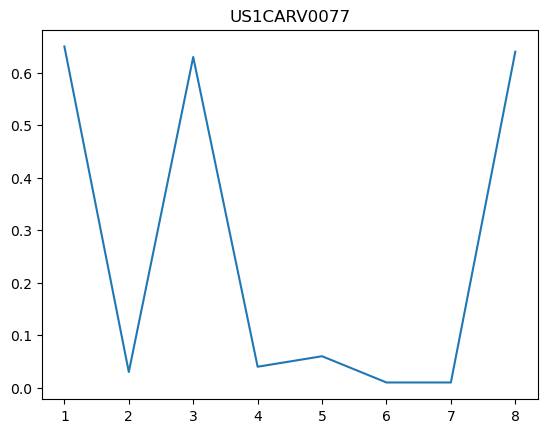

US1CARV0078
[0.65 0.03 0.63 0.04 0.06 0.01 0.01 0.64]


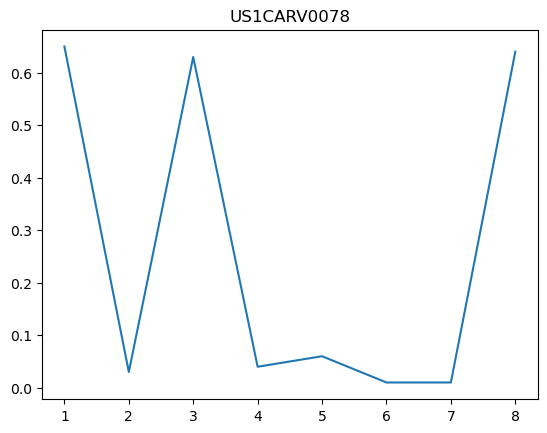

US1CARV0079
[0.65 0.03 0.63 0.04 0.06 0.01 0.01 0.64]


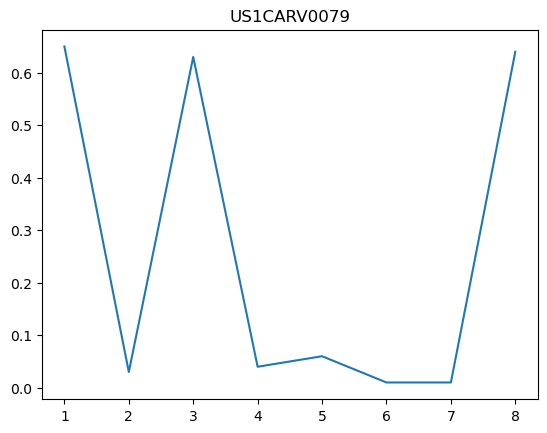

US1CARV0081
[0.65 0.03 0.63 0.04 0.06 0.01 0.01 0.64]


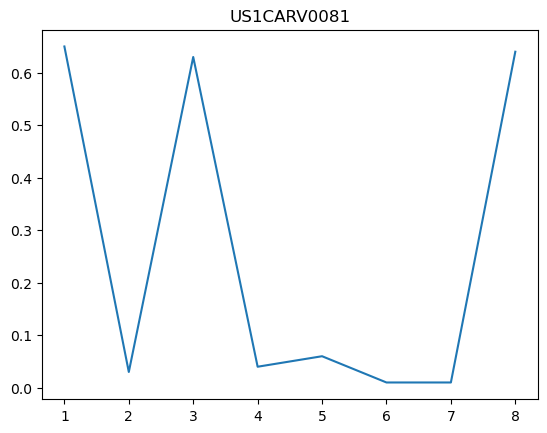

USC00040924
[0.65 0.03 0.63 0.04 0.06 0.01 0.01 0.64]


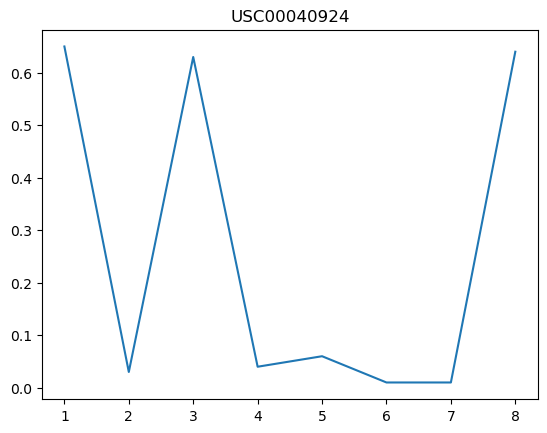

USC00041738
[0.65 0.03 0.63 0.04 0.06 0.01 0.01 0.64]


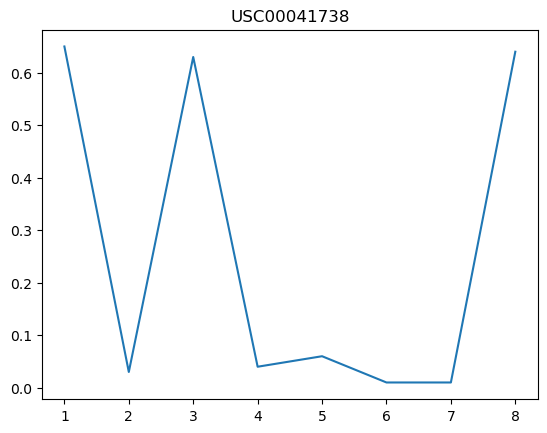

USC00042327
[0.65 0.03 0.63 0.04 0.06 0.01 0.01 0.64]


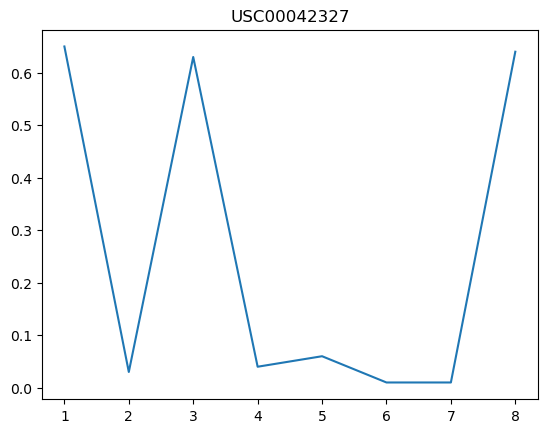

USC00042598
[0.65 0.03 0.63 0.04 0.06 0.01 0.01 0.64]


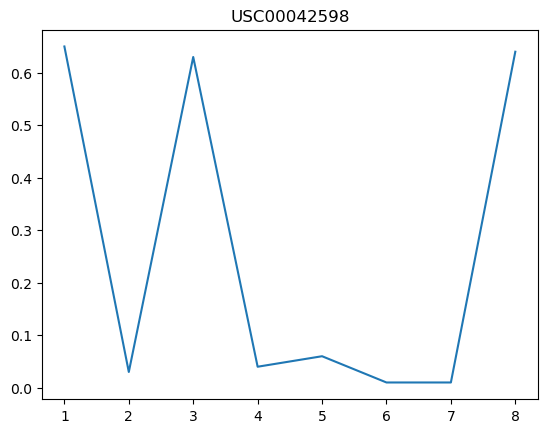

USC00042805
[0.65 0.03 0.63 0.04 0.06 0.01 0.01 0.64]


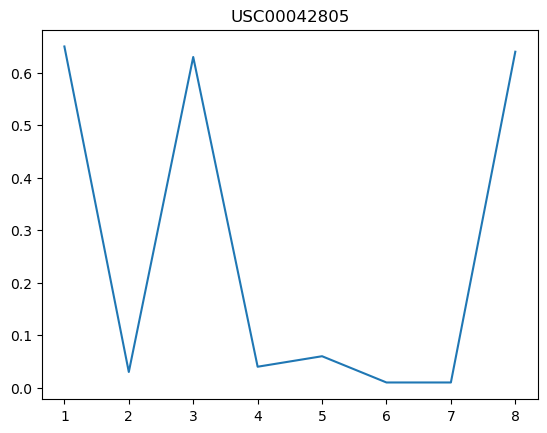

USC00043855
[0.65 0.03 0.63 0.04 0.06 0.01 0.01 0.64]


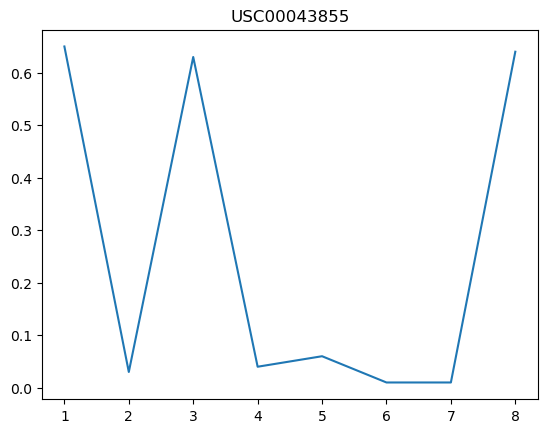

USC00043896
[0.65 0.03 0.63 0.04 0.06 0.01 0.01 0.64]


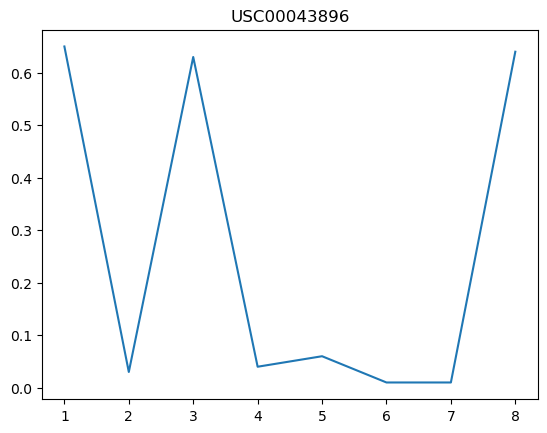

USC00044211
[0.65 0.03 0.63 0.04 0.06 0.01 0.01 0.64]


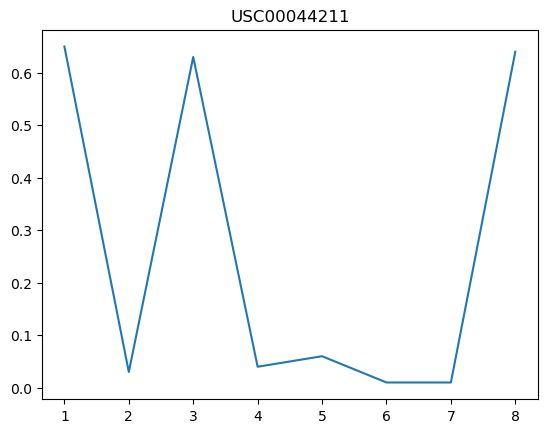

USC00044259
[0.65 0.03 0.63 0.04 0.06 0.01 0.01 0.64]


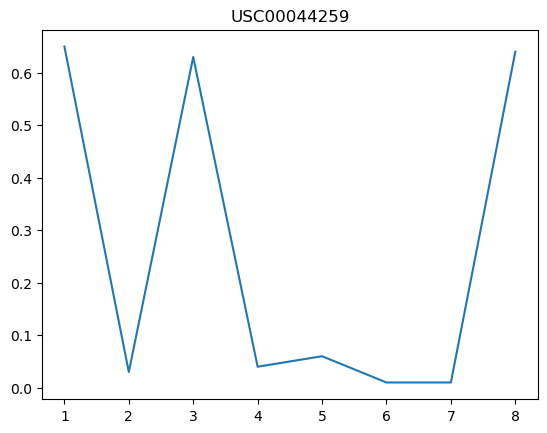

USC00045091
[0.65 0.03 0.63 0.04 0.06 0.01 0.01 0.64]


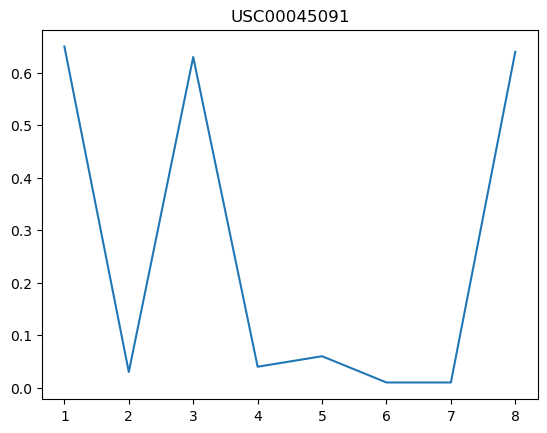

USC00045502
[0.65 0.03 0.63 0.04 0.06 0.01 0.01 0.64]


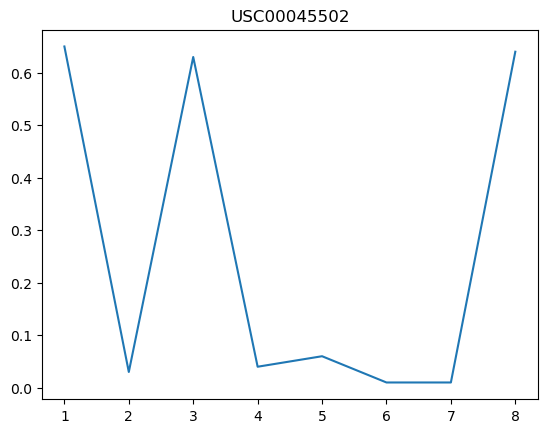

USC00046635
[0.65 0.03 0.63 0.04 0.06 0.01 0.01 0.64]


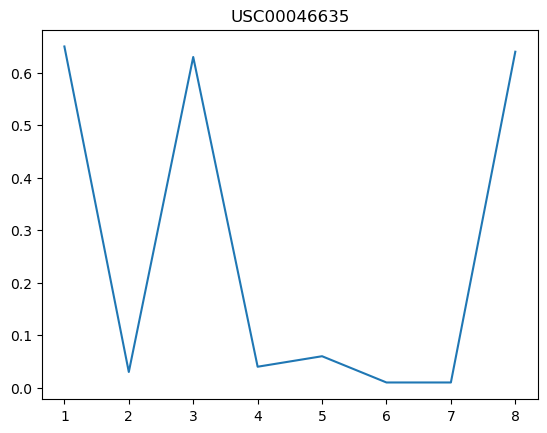

USC00047470
[0.65 0.03 0.63 0.04 0.06 0.01 0.01 0.64]


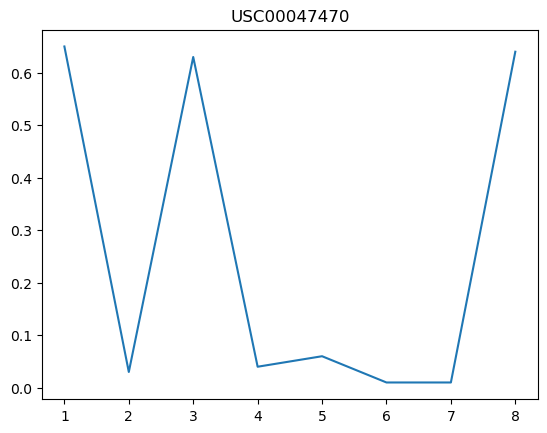

USC00047813
[0.65 0.03 0.63 0.04 0.06 0.01 0.01 0.64]


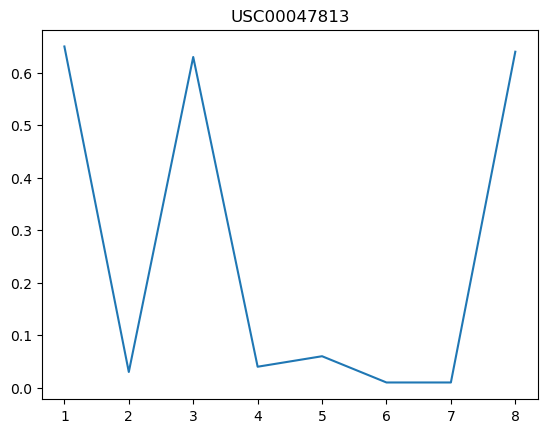

USR0000CANZ
[0.65 0.03 0.63 0.04 0.06 0.01 0.01 0.64]


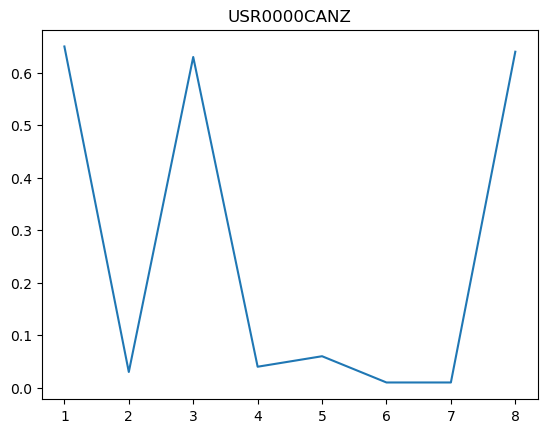

USR0000CBEU
[0.65 0.03 0.63 0.04 0.06 0.01 0.01 0.64]


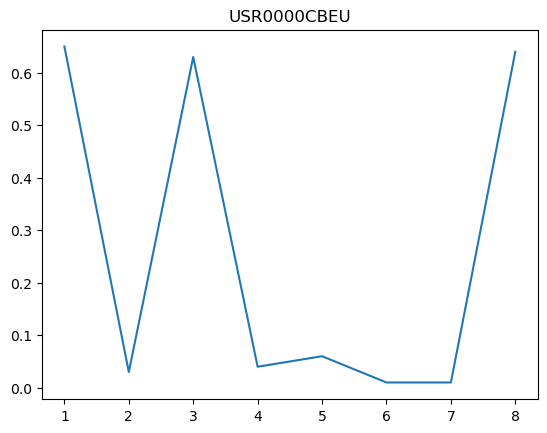

USR0000CCLK
[0.65 0.03 0.63 0.04 0.06 0.01 0.01 0.64]


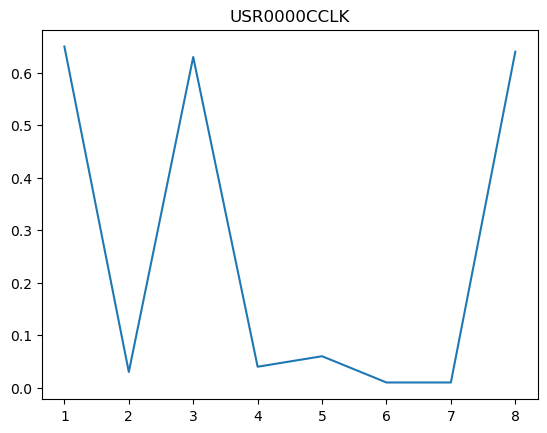

USR0000CCRT
[0.65 0.03 0.63 0.04 0.06 0.01 0.01 0.64]


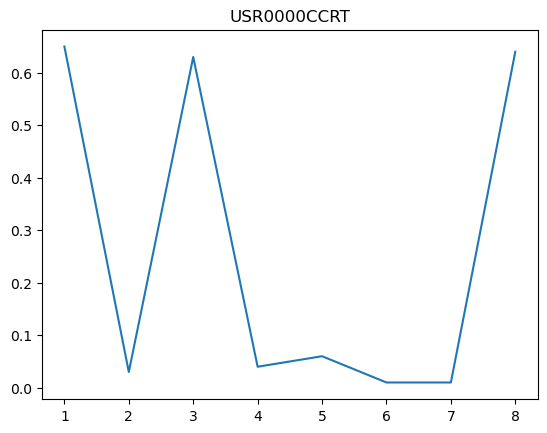

USR0000CELC
[0.65 0.03 0.63 0.04 0.06 0.01 0.01 0.64]


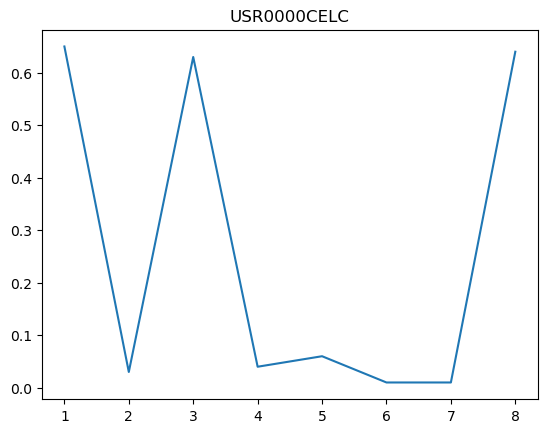

USR0000CKEE
[0.65 0.03 0.63 0.04 0.06 0.01 0.01 0.64]


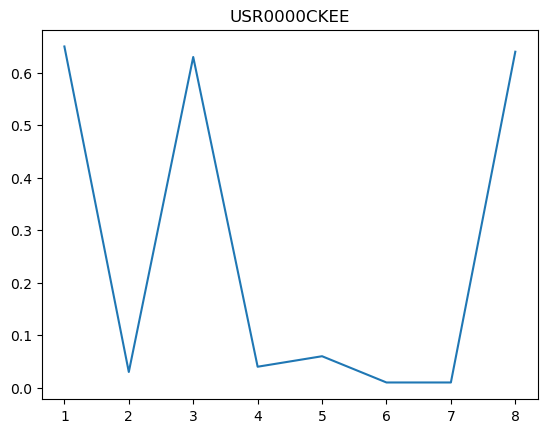

USR0000CLHO
[0.65 0.03 0.63 0.04 0.06 0.01 0.01 0.64]


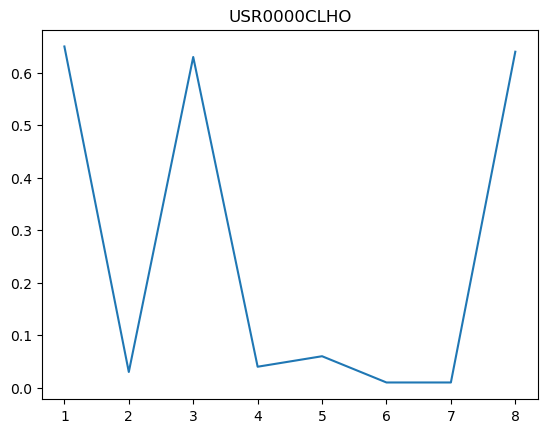

USR0000CRIC


KeyboardInterrupt: 

In [91]:
last_20_weeks_df = pd.DataFrame()
for station_name, group in newTestWeatherDf.groupby('STATION'):

    if len(group)>=20:
        print(station_name)

        weatherData = group[features]

        window_size = 20
        #features with fire
        #features = ['AWND', 'AVG PRECIP', 'TOTAL PRECIP','AVG SNOW','TOTAL SNOW','AVG TEMP','AVG MAX TEMP','MAX TEMP','AVG MIN TEMP','MIN TEMP','LATITUDE','LONGITUDE','ELEVATION', 'fire']
        features = ['AWND', 'AVG PRECIP', 'TOTAL PRECIP','AVG SNOW','TOTAL SNOW','AVG TEMP','AVG MAX TEMP','MAX TEMP','AVG MIN TEMP','MIN TEMP','LATITUDE','LONGITUDE','ELEVATION']
        # Split data into features and target
        X = combined_data[features]  # Features

        # Apply rolling window to create sequences of inputs and targets
        X_rolling = []

        group_size = len(group)
        # Iterate within the current group
        for i in range(group_size - window_size + 1):

            X_rolling.append(group_data[features].iloc[i:i+window_size].values.flatten())


        # Convert to numpy arrays
        X_rolling = pd.DataFrame(X_rolling)


        stationPredictions = np.array(model.predict_proba(X_rolling))[:,:,1]
        stationPredictionsDf = pd.DataFrame(stationPredictions).transpose()
        last_row_predictions = np.array(stationPredictionsDf.head(1))[0]
        print(last_row_predictions)
        plt.plot([1,2,3,4,5,6,7,8],last_row_predictions)
        plt.title(station_name)
        plt.show()
        
        #print(stationPredictionsDf.shape)#rows, columns
        
        

        
